In [1]:
import os
import time
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import CheckpointCallback, EvalCallback, BaseCallback
from stable_baselines3.common.env_util import make_vec_env
# from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3.common.monitor import Monitor
import numpy as np

2024-12-22 06:57:29.341842: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-22 06:57:29.420829: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-22 06:57:30.699042: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [16]:
chk_path = "walker-2d"
env_name = "Walker2d-v5"
algorithm = "ppo"

In [ ]:
os.makedirs(os.path.join(chk_path, env_name), exist_ok=True)

In [ ]:
vec_env = make_vec_env(lambda: Monitor(gym.make(env_name)), n_envs=4)

In [ ]:
env = Monitor(gym.make(env_name))


In [ ]:
checkpoint_callback = CheckpointCallback(save_freq=50000, save_path=chk_path, name_prefix=env_name)
eval_callback = EvalCallback(
    env,
    best_model_save_path=chk_path,
    log_path=os.path.join(chk_path, "eval_logs"),
    eval_freq=10000,
    deterministic=True,
    render=False,
)

In [ ]:
model = PPO("MlpPolicy", env, verbose=1, tensorboard_log=chk_path)

Using cpu device
Wrapping the env in a DummyVecEnv.


In [ ]:
# try:
#     print("training started...")
#     total_training_time = 3 * 60 * 60  # 3 hours
#     start_time = time.time()

#     while time.time() - start_time < total_training_time:
#         model.learn(
#             total_timesteps=200000,
#             callback=[checkpoint_callback, eval_callback],progress_bar=True,)
#         model.save(os.path.join(chk_path, f"{env_name}_latest"))

# except KeyboardInterrupt:
#     print("Keyboard. Saving latest model: ")
#     model.save(os.path.join(chk_path, f"{env_name}_interrupted"))

# model.save(os.path.join(chk_path, f"{env_name}_final"))
# vec_env.close()
# env.close()

  78% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━ 156,714/200,000  [ 0:08:21 < 0:02:20 , 311 it/s ]

In [ ]:
rewards_path = "/content/drive/MyDrive/RL_Checkpoints/walker-2d/rewards.npy"
rewards = np.load(rewards_path)
print(type(rewards))
print(rewards.shape)
print(rewards[:10])


<class 'numpy.ndarray'>
(1,)
[278.23536]


In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy


model = PPO.load(os.path.join(chk_path, f"{env_name}_final"))
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"Trained Agent: Mean Reward = {mean_reward}, Std Reward = {std_reward}")

random_agent = lambda _: env.action_space.sample()
random_rewards = []
for _ in range(10):
    obs,_ = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = random_agent(obs)
        obs, reward, terminate, truncate ,_= env.step(action)
        done = terminate or truncate
        total_reward += reward
    random_rewards.append(total_reward)

print(f"Random Agent: Mean Reward = {np.mean(random_rewards)}, Std Reward = {np.std(random_rewards)}")


Trained Agent: Mean Reward = 3430.7407297000004, Std Reward = 978.7313230987836
Random Agent: Mean Reward = 3.8348914801469305, Std Reward = 7.398245157898135


In [7]:
len(eval_data["timesteps"]),len(eval_data["results"])

(296, 296)

In [12]:
eval_data["results"][0]

array([246.337363, 254.271934, 253.868432, 249.483219, 252.989225])

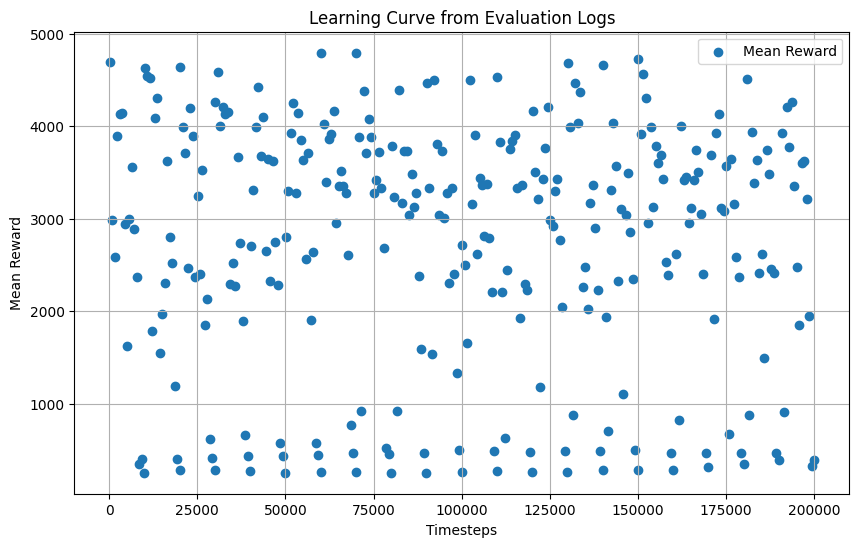

In [15]:
eval_logs_path = "./walker-2d/eval_logs/evaluations.npz"
eval_data = np.load(eval_logs_path)



timesteps = eval_data["timesteps"]
mean_rewards = eval_data["results"].mean(axis=1)
std_rewards = eval_data["results"].std(axis=1)

plt.figure(figsize=(10, 6))
plt.scatter(timesteps, mean_rewards, label="Mean Reward")
# plt.fill_between(
#     timesteps,
#     mean_rewards - std_rewards,
#     mean_rewards + std_rewards,
#     alpha=0.2,
#     label="Standard Deviation",
# )
plt.xlabel("Timesteps")
plt.ylabel("Mean Reward")
plt.title("Learning Curve from Evaluation Logs")
plt.legend()
plt.grid()
plt.show()


In [19]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def extract_plots(log_dir, output_dir):
    """
    Extract and save all plots from a TensorBoard logs directory.

    Args:
        log_dir (str): Path to the TensorBoard logs directory.
        output_dir (str): Path to save the output plots.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Load TensorBoard logs
    event_acc = EventAccumulator(log_dir)
    event_acc.Reload()

    # Extract scalar keys
    scalar_keys = event_acc.Tags().get('scalars', [])
    
    for key in scalar_keys:
        # Get scalar data
        events = event_acc.Scalars(key)
        steps = [e.step for e in events]
        values = [e.value for e in events]
        
        # Plot data
        plt.figure()
        plt.plot(steps, values, label=key)
        plt.xlabel("Steps")
        plt.ylabel("Value")
        plt.title(f"Plot for {key}")
        plt.legend()
        plt.grid(True)

        # Save plot
        plot_path = os.path.join(output_dir, f"{key.replace('/', '_')}.png")
        plt.savefig(plot_path)
        plt.close()
        print(f"Saved plot: {plot_path}")

# Example usage
for i in range(21):

    log_dir = os.path.join(chk_path,f"PPO_{i+1}") # Replace with your logs directory
    output_dir = f"tensorboard/PPO_{i}"  # Replace with your desired output directory
    extract_plots(log_dir, output_dir)


Saved plot: tensorboard/PPO_0/rollout_ep_len_mean.png
Saved plot: tensorboard/PPO_0/rollout_ep_rew_mean.png
Saved plot: tensorboard/PPO_0/time_fps.png
Saved plot: tensorboard/PPO_0/train_approx_kl.png
Saved plot: tensorboard/PPO_0/train_clip_fraction.png
Saved plot: tensorboard/PPO_0/train_clip_range.png
Saved plot: tensorboard/PPO_0/train_entropy_loss.png
Saved plot: tensorboard/PPO_0/train_explained_variance.png
Saved plot: tensorboard/PPO_0/train_learning_rate.png
Saved plot: tensorboard/PPO_0/train_loss.png
Saved plot: tensorboard/PPO_0/train_policy_gradient_loss.png
Saved plot: tensorboard/PPO_0/train_std.png
Saved plot: tensorboard/PPO_0/train_value_loss.png
Saved plot: tensorboard/PPO_3/rollout_ep_len_mean.png
Saved plot: tensorboard/PPO_3/rollout_ep_rew_mean.png
Saved plot: tensorboard/PPO_3/time_fps.png
Saved plot: tensorboard/PPO_3/train_approx_kl.png
Saved plot: tensorboard/PPO_3/train_clip_fraction.png
Saved plot: tensorboard/PPO_3/train_clip_range.png
Saved plot: tensorboa